In [1]:
from collections import defaultdict
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

import config

In [2]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
from IPython.display import display, HTML

CSS_Flex = """
.output {
    flex-direction: row;
}
"""

CSS_Orig = """
.output {
    flex-direction: column;
}
"""
def row_wise():
    HTML('<style>{}</style>'.format(CSS_Flex))
    
def column_wise():
    HTML('<style>{}</style>'.format(CSS_Orig))

# Import Tasks and Label Data

In [3]:
tasks_json = json.load(open(config.TASK_MAP_FILE))
tasks = defaultdict(dict)
task_attr_sets = defaultdict(set)
task_label_sets = defaultdict(set)
id_to_task_dict = {}
for task in tasks_json['taskInfo']:
    obj, attr = task['taskName'].split(':')
    id_to_task_dict[task['taskId']] = task['taskName']
    tasks[obj][attr] = task['taskId']
    task_attr_sets[obj].add(attr)
    task_label_sets[obj].add(task['taskId'])

In [4]:
objects = list(tasks.keys())
attr_rows = []
label_rows = []
for i in objects:
    row_attr = []
    row_label = []
    for j in objects:
        row_attr.append(len(task_attr_sets[i].intersection(task_attr_sets[j])))
        row_label.append(len(task_label_sets[i].intersection(task_label_sets[j])))
    attr_rows.append(row_attr)
    label_rows.append(row_label)
df_attr_intersection = pd.DataFrame(attr_rows, index=objects, columns=objects)
df_id_intersection = pd.DataFrame(label_rows, index=objects, columns=objects)

# Object And Attribute/TaskID Intersection

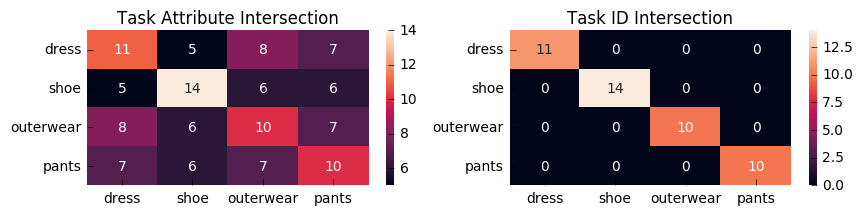

In [5]:
plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.title('Task Attribute Intersection')
sns.heatmap(df_attr_intersection, annot=True)
plt.subplot(1, 2, 2)
plt.title('Task ID Intersection')
sns.heatmap(df_id_intersection, annot=True)
plt.show()

# Import Train and Valid Data

In [6]:
train_data = json.load(open(config.TRAIN_DATA_FILE))
downloaded_train_data = os.listdir(config.TRAIN_IMAGES_DIR)
train_rows = []
for annotation in tqdm(train_data['annotations']):
    if annotation['imageId'] + ".jpg" in downloaded_train_data:
        train_rows.append([
            config.TRAIN_IMAGES_DIR + "/" + annotation['imageId'] + ".jpg", 
            annotation['labelId'], 
            annotation['taskId']
        ])
df_train = pd.DataFrame(train_rows, columns=['imageId', 'labelId', 'taskId'])
valid_data = json.load(open(config.VALID_DATA_FILE))
downloaded_valid_data = os.listdir(config.VALID_IMAGES_DIR)
valid_rows = []
for annotation in tqdm(valid_data['annotations']):
    if annotation['imageId'] + ".jpg" in downloaded_valid_data:
        valid_rows.append([
            config.VALID_IMAGES_DIR + "/" + annotation['imageId'] + ".jpg", 
            annotation['labelId'], 
            annotation['taskId']
        ])
df_valid = pd.DataFrame(valid_rows, columns=['imageId', 'labelId', 'taskId'])

# Task Distribution

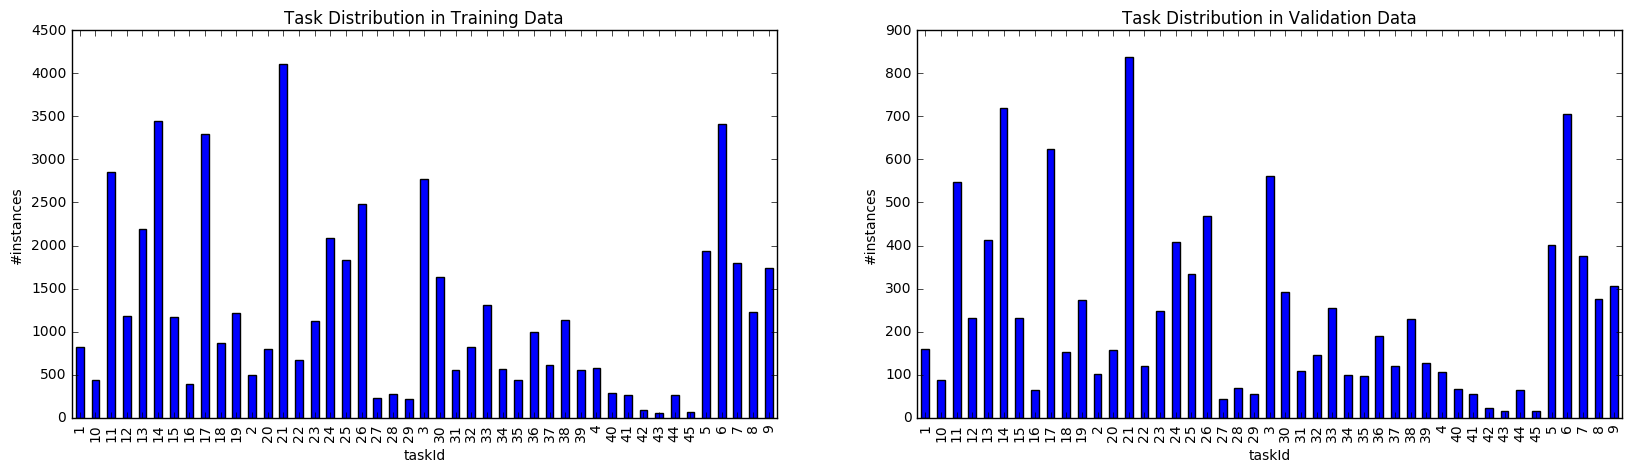

In [7]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
df_train.taskId.value_counts().sort_index().plot(kind='bar')
plt.title('Task Distribution in Training Data')
plt.xlabel('taskId')
plt.ylabel('#instances')
plt.subplot(1, 2, 2)
df_valid.taskId.value_counts().sort_index().plot(kind='bar')
plt.title('Task Distribution in Validation Data')
plt.xlabel('taskId')
plt.ylabel('#instances')
plt.show()

# Task Label Intersection

In [8]:
task_ids = df_train.taskId.unique().tolist()
task_label_rows = []
for i in task_ids:
    row = []
    for j in task_ids:
        intersection = set(
            df_train[df_train.taskId == i].labelId.unique()
        ).intersection(
            df_train[df_train.taskId == j].labelId.unique()
        )
        row.append(len(intersection))
    task_label_rows.append(row)

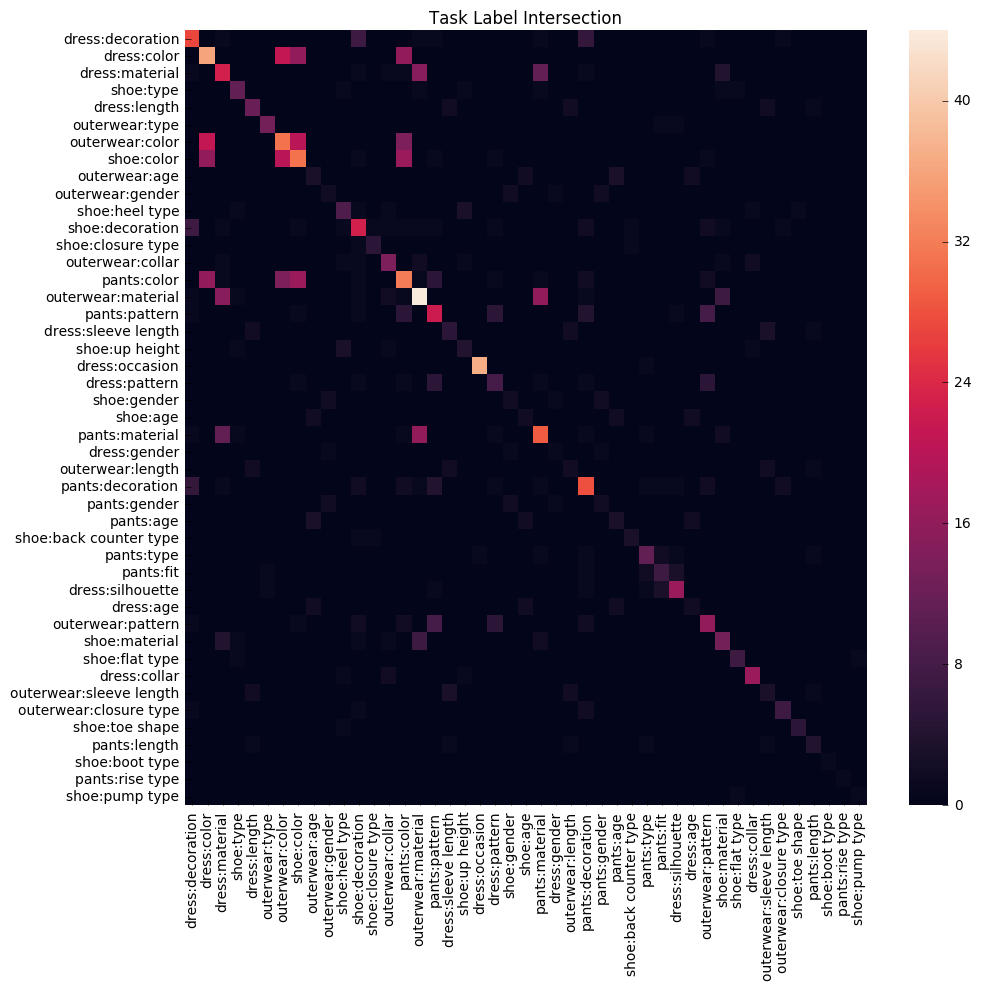

In [9]:
tasks = [id_to_task_dict[_] for _ in task_ids]
df_task_label_intersection = pd.DataFrame(task_label_rows, index=tasks, columns=tasks)
plt.figure(figsize=(11, 10))
plt.title('Task Label Intersection')
sns.heatmap(df_task_label_intersection, annot=False)
plt.show()

# Task Label Distribution

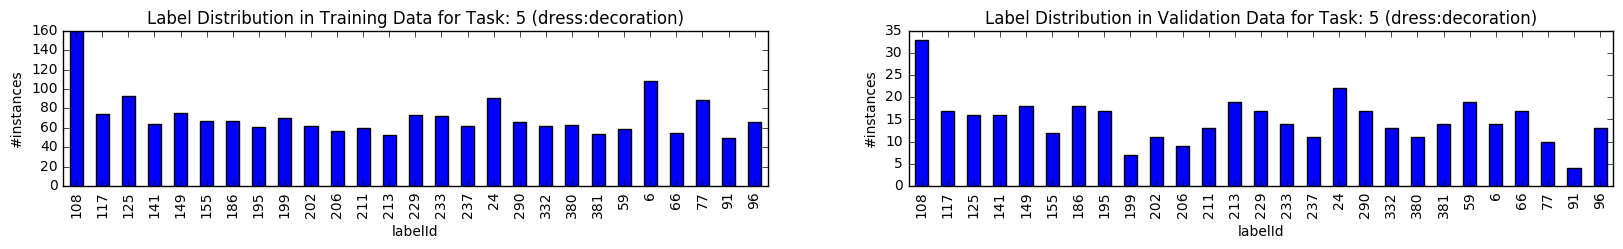

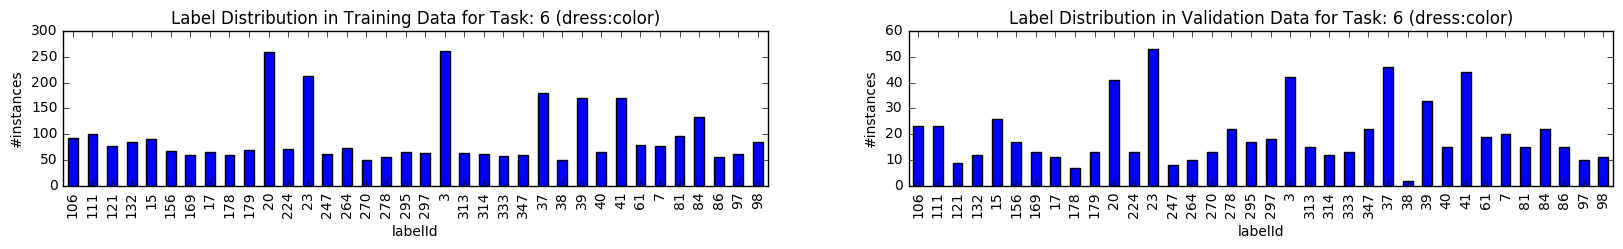

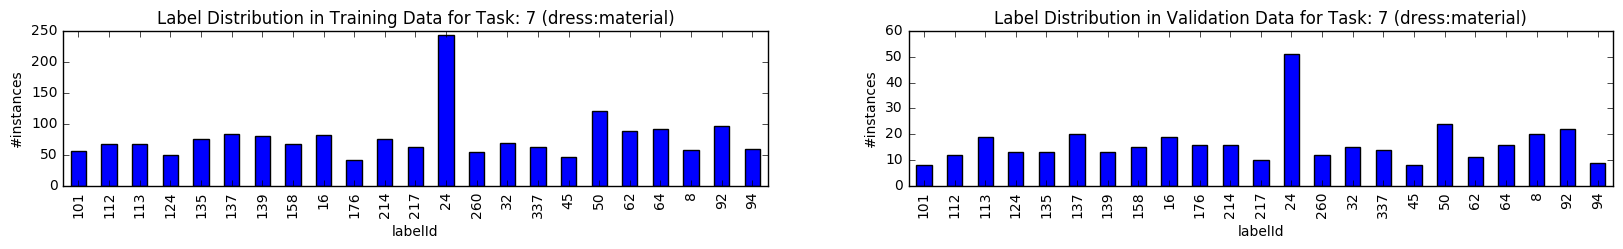

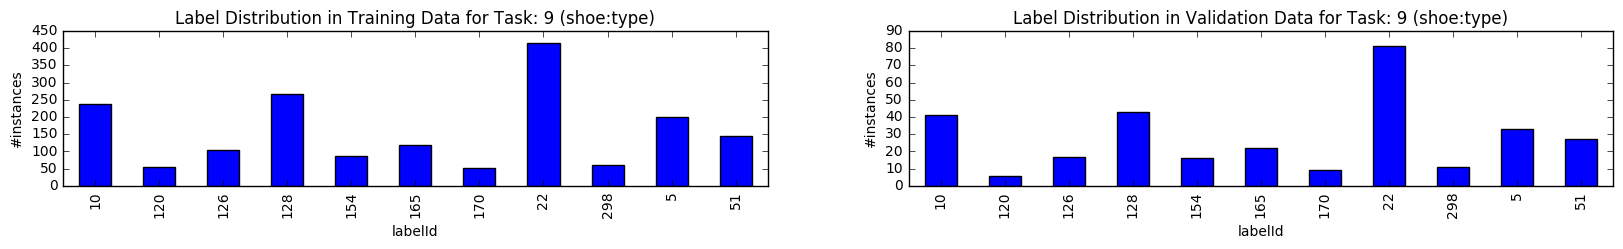

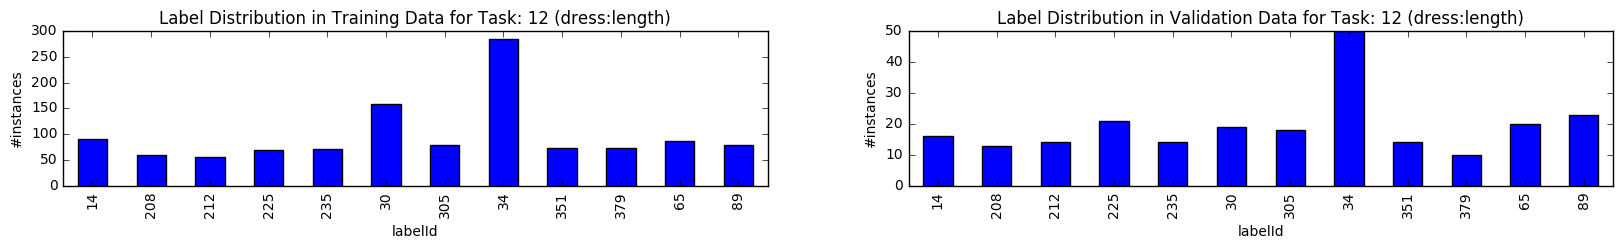

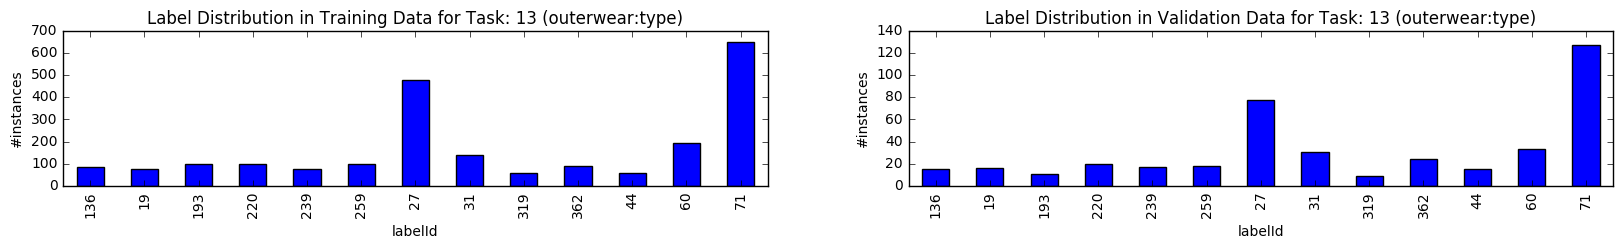

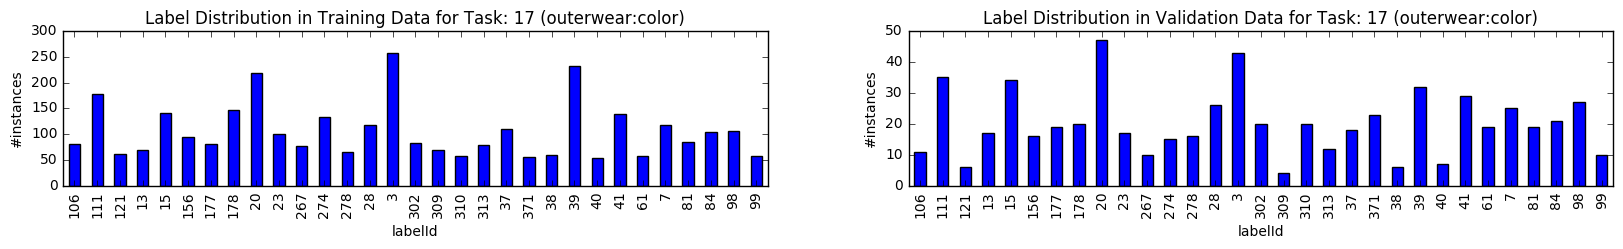

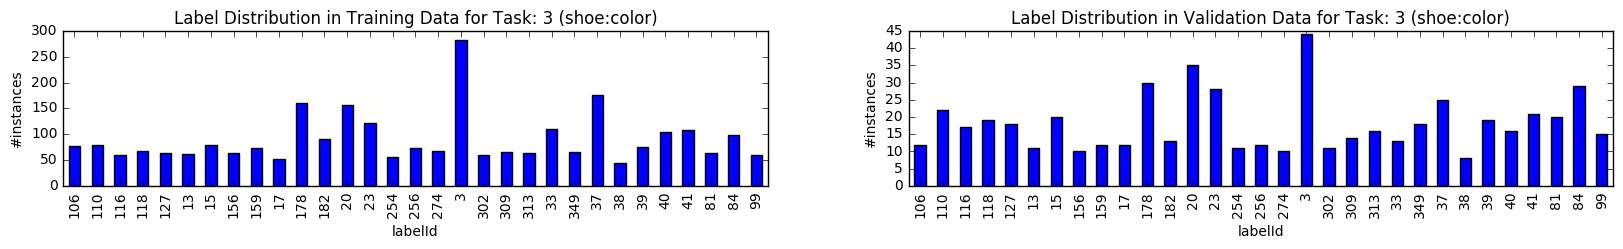

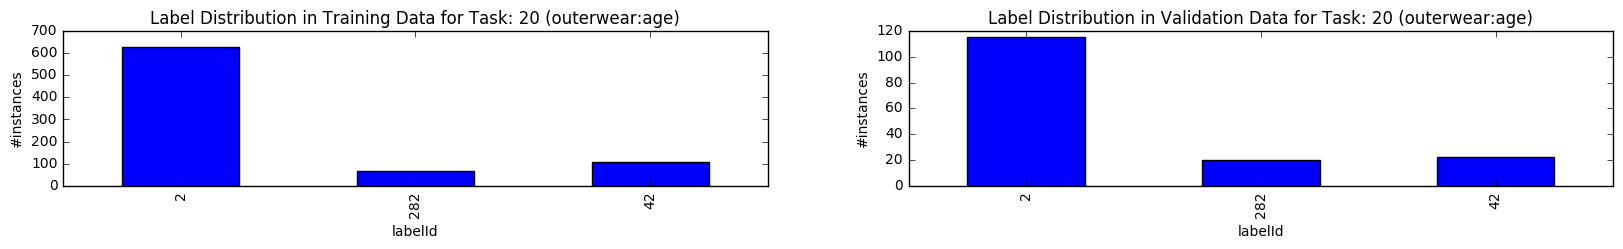

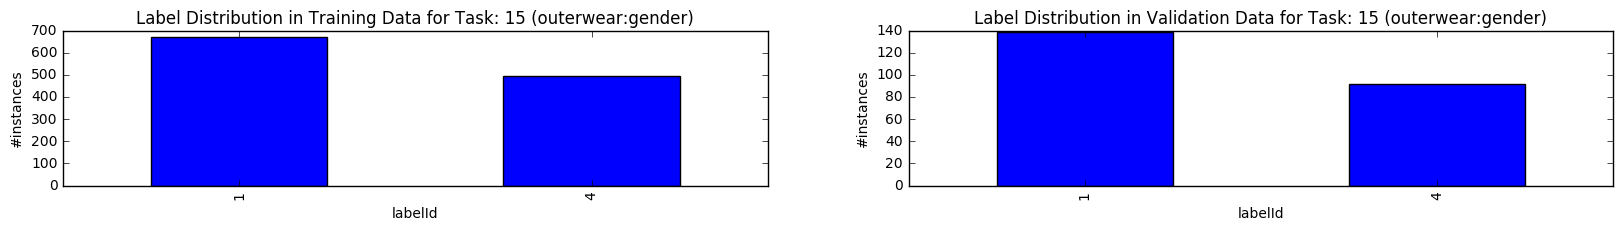

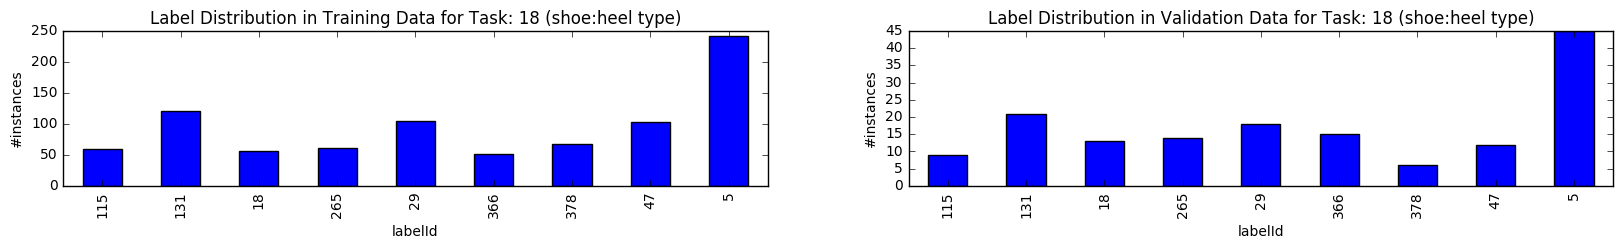

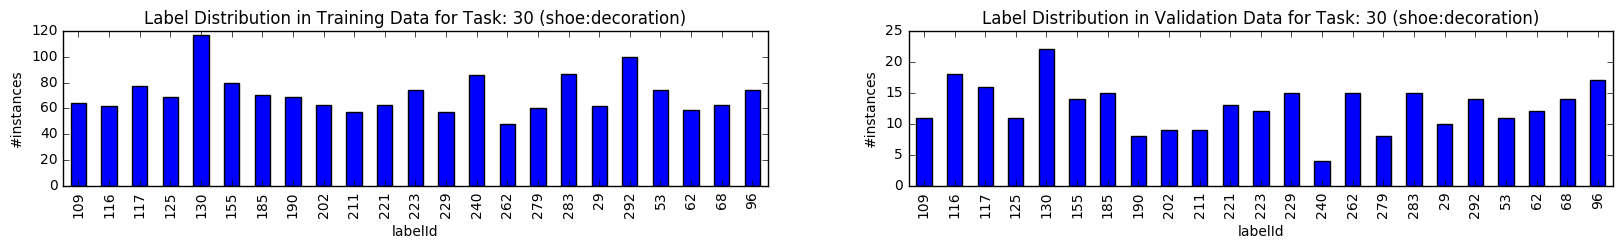

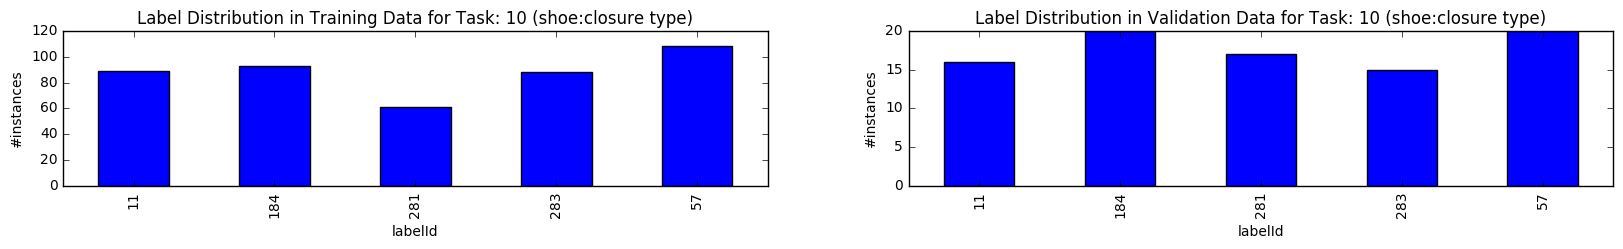

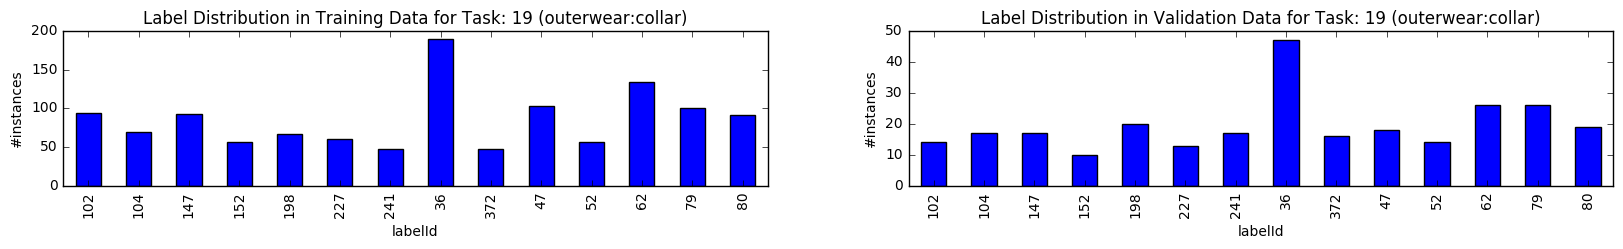

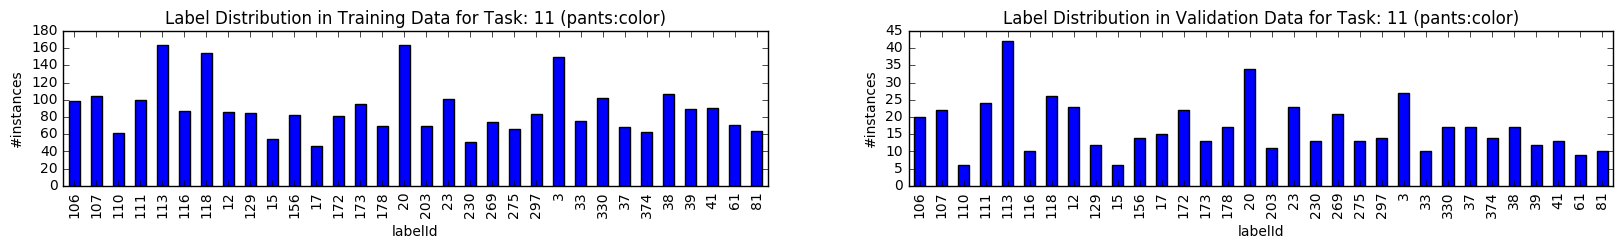

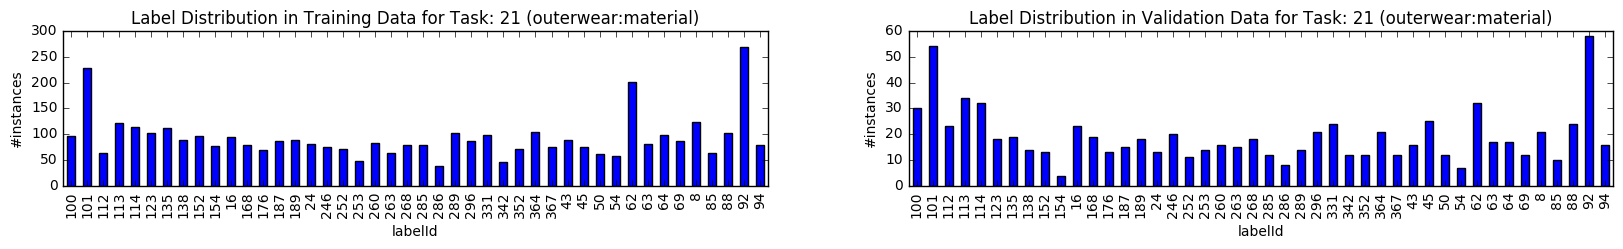

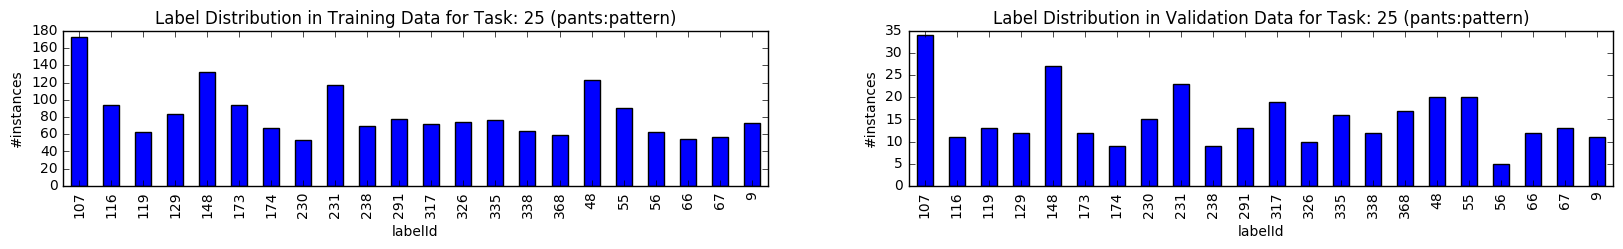

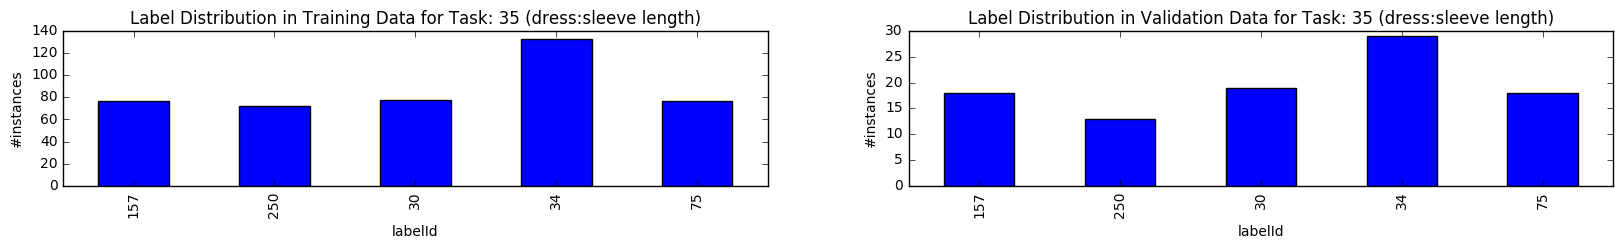

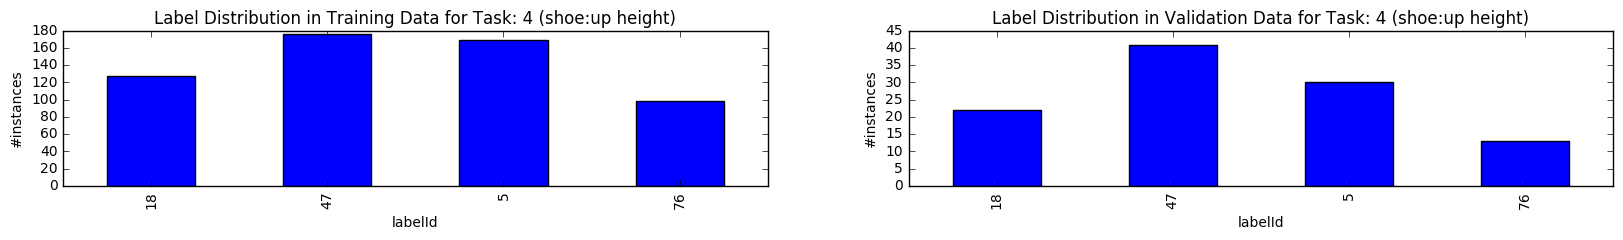

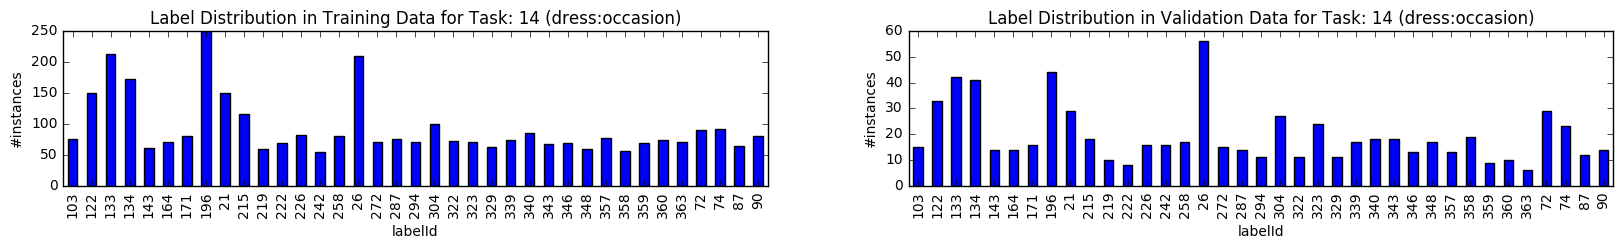

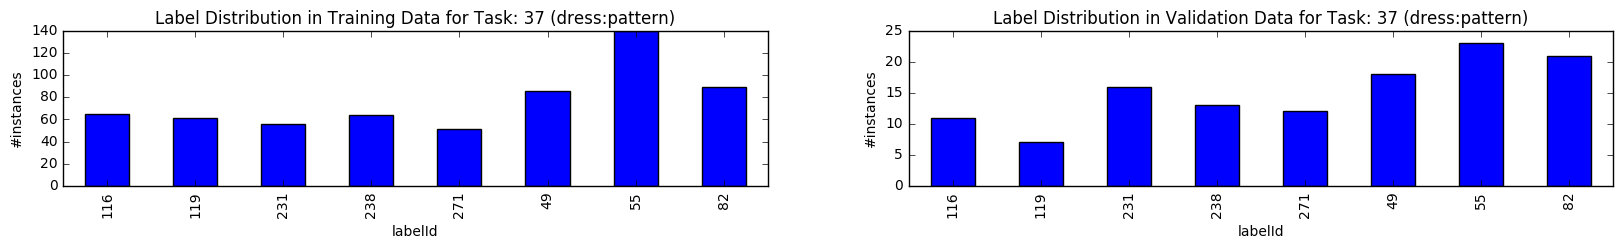

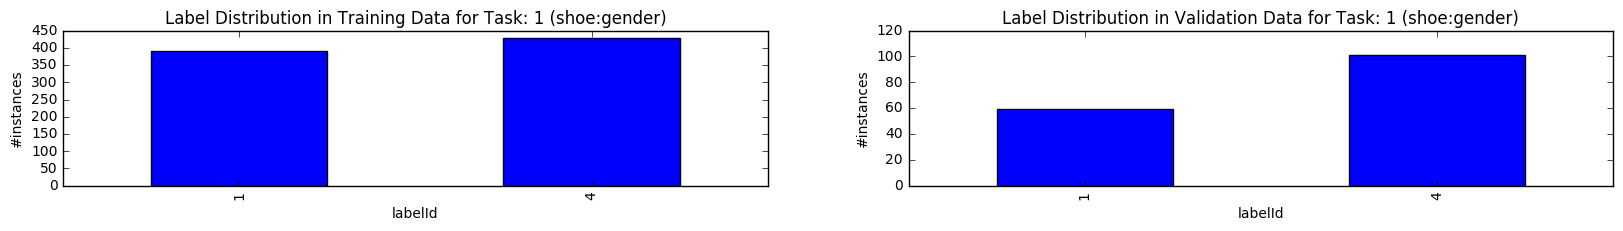

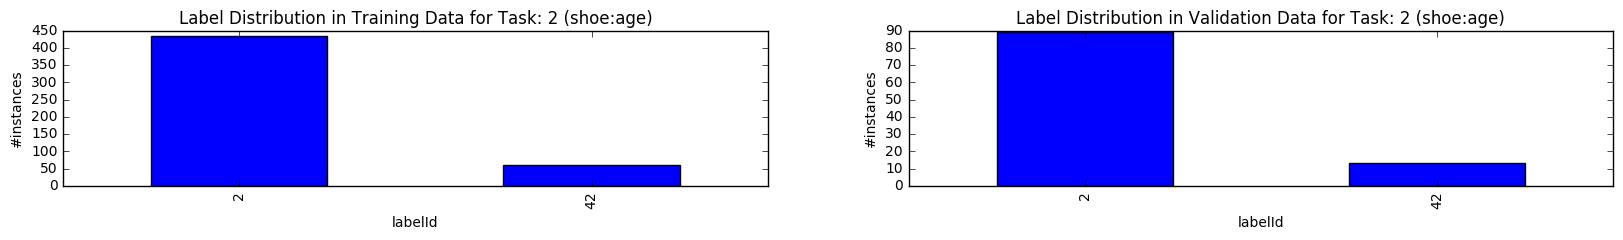

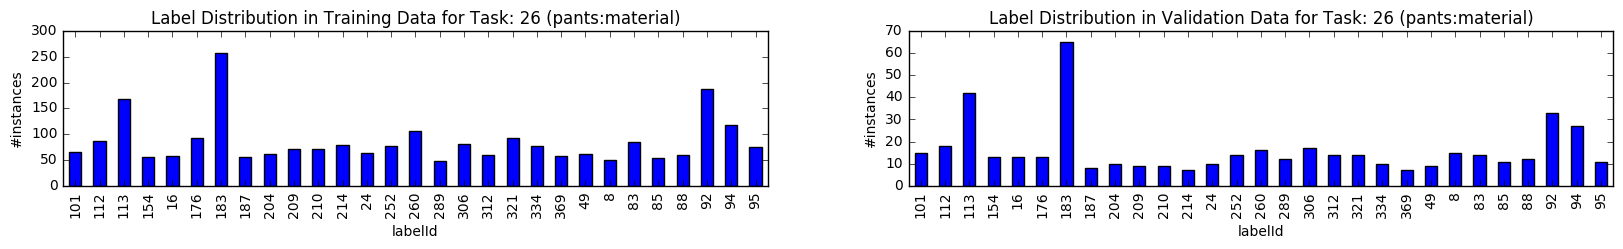

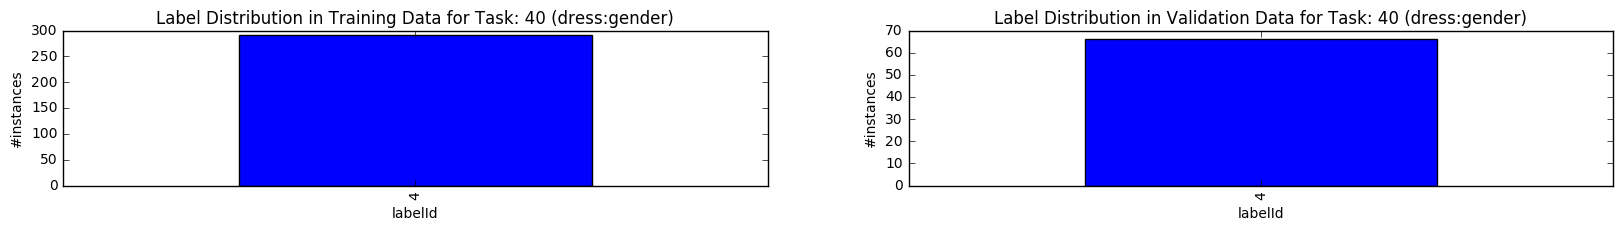

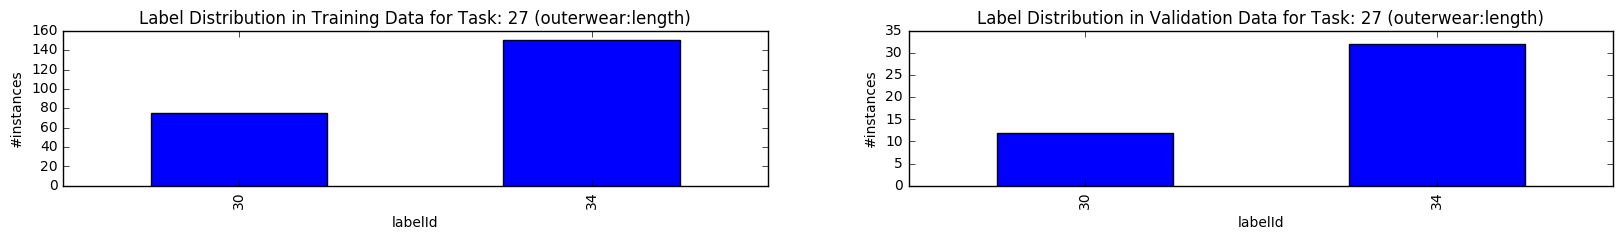

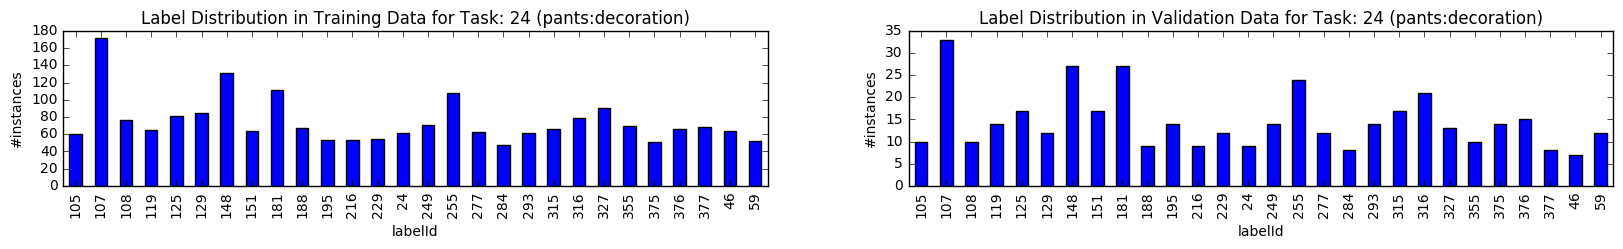

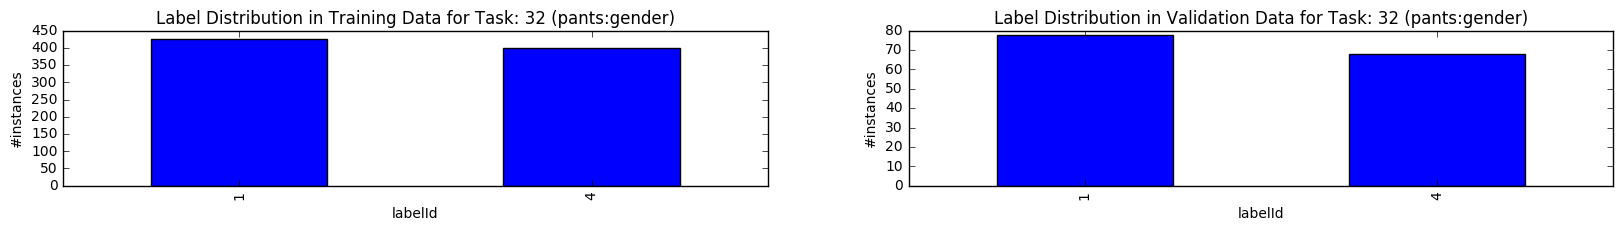

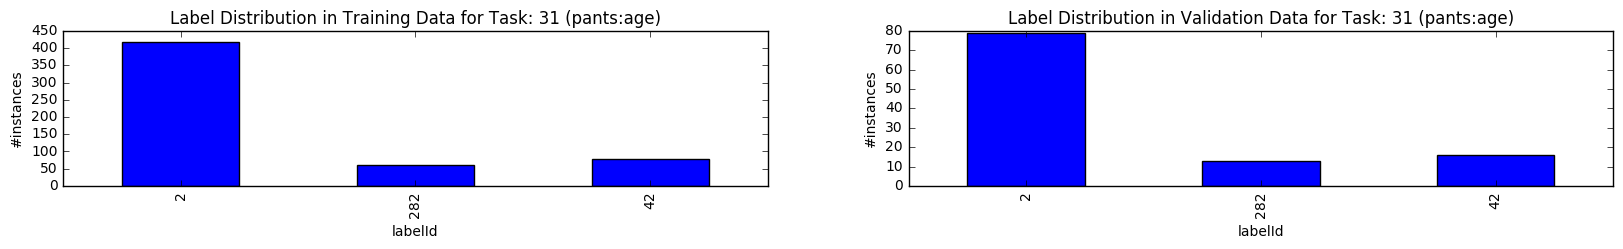

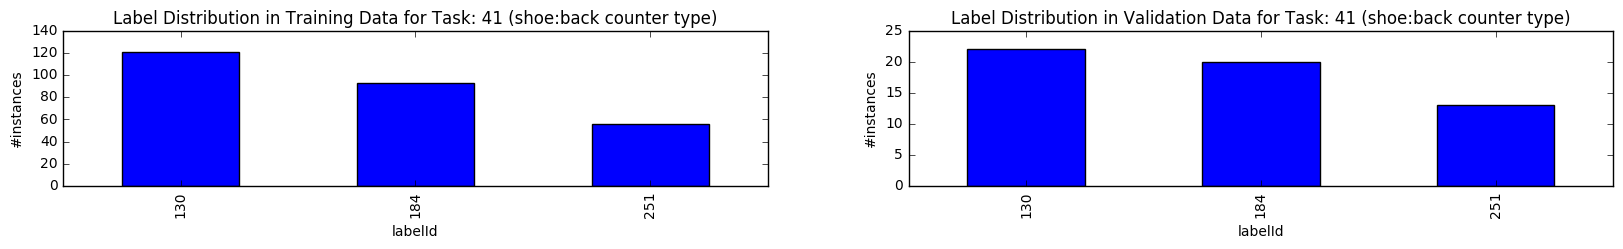

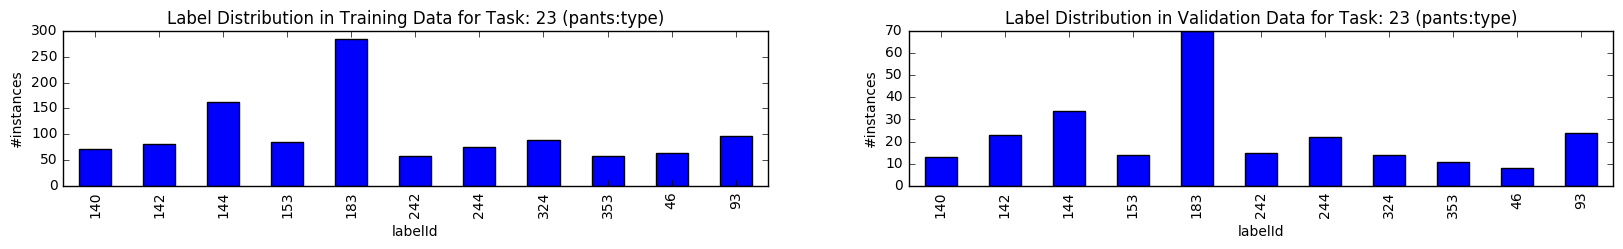

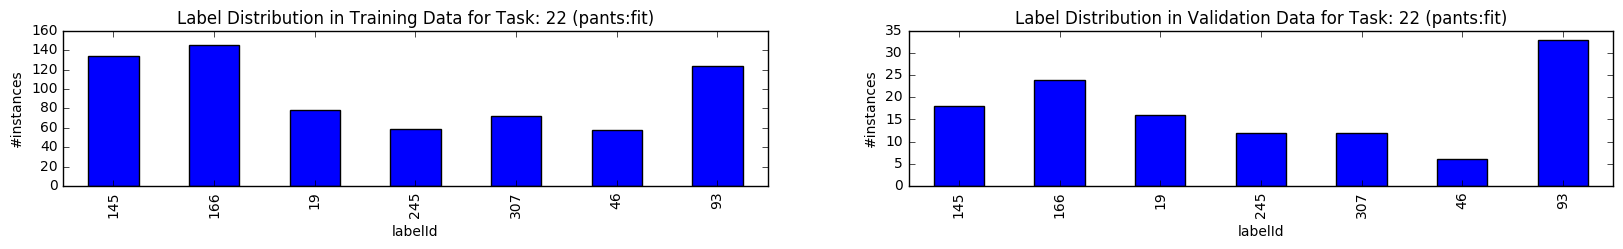

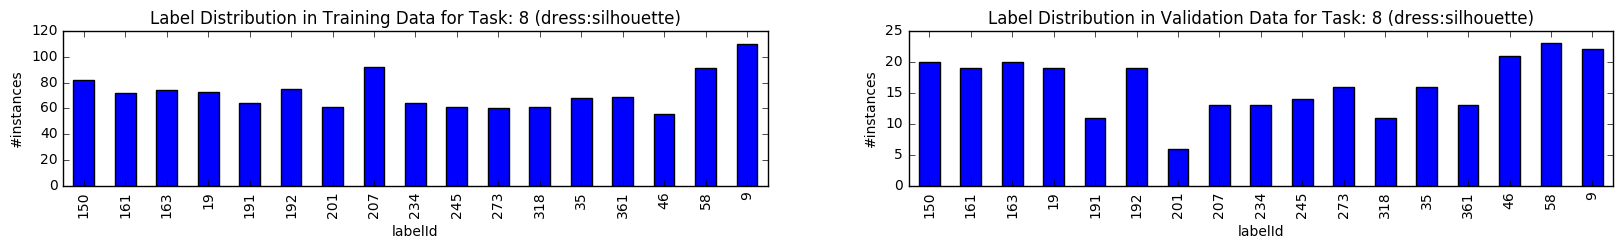

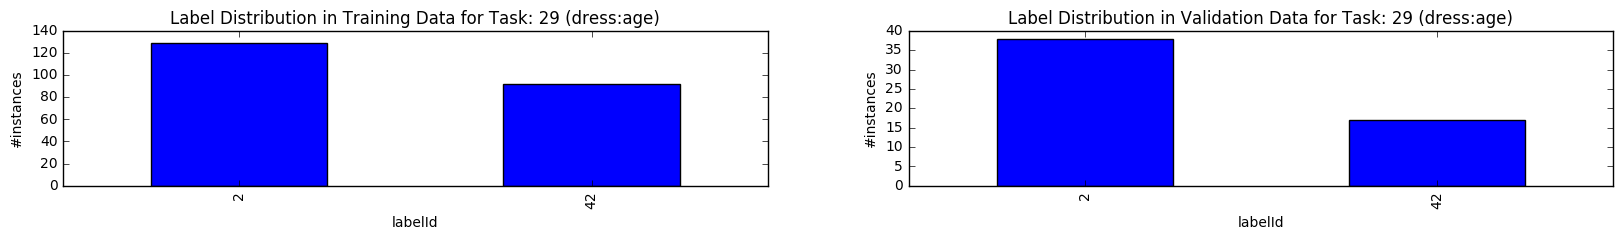

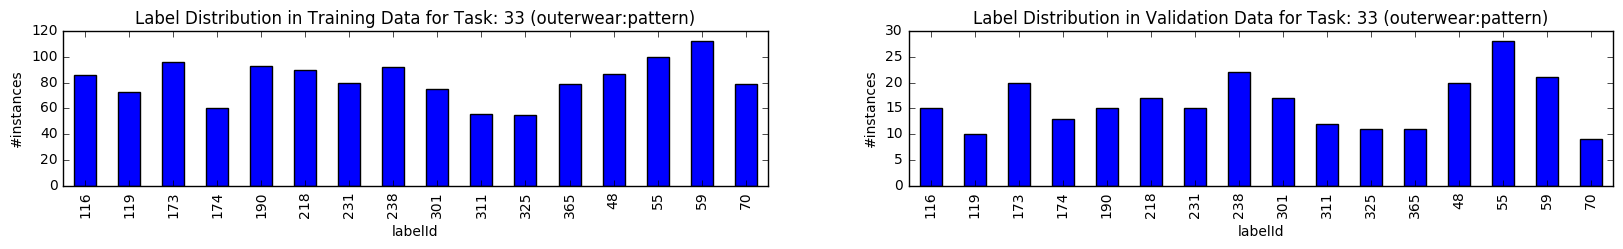

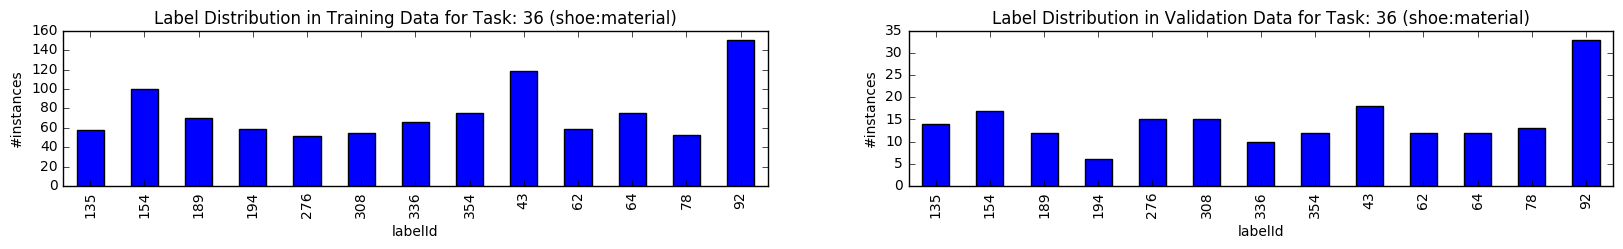

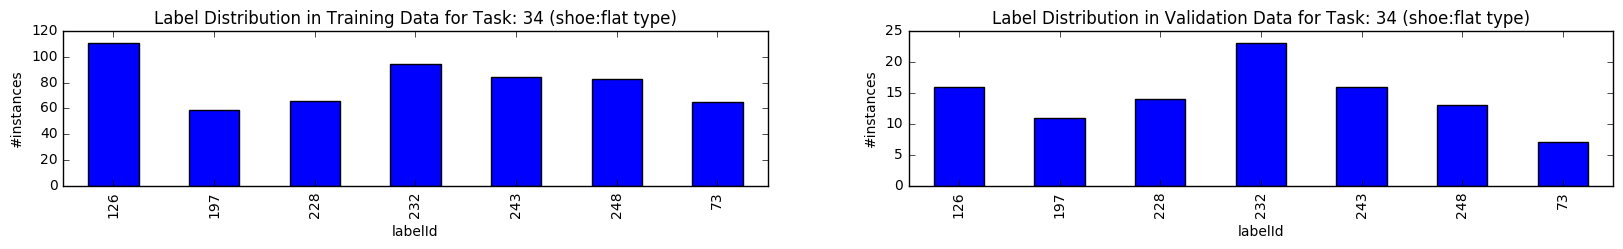

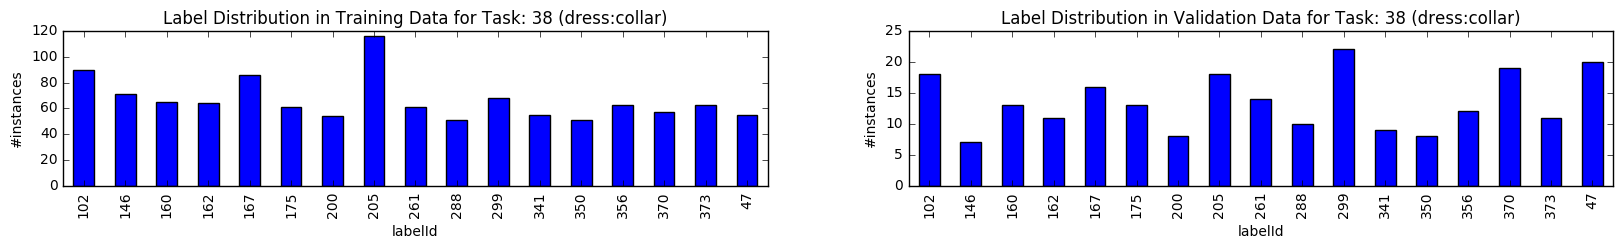

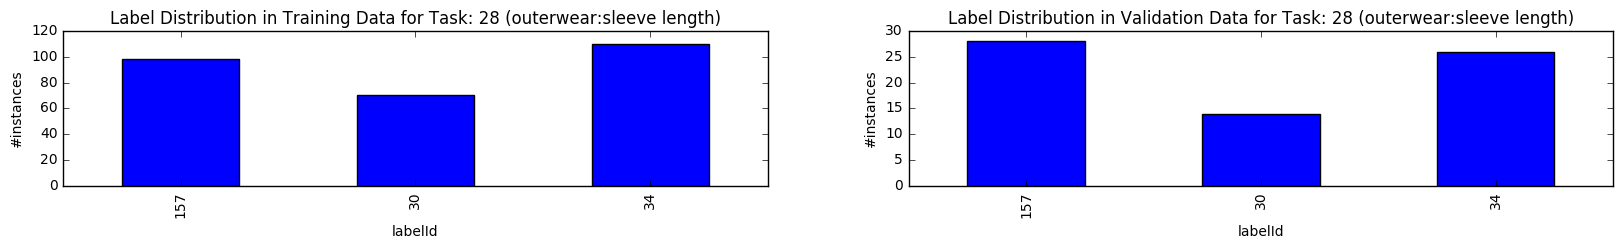

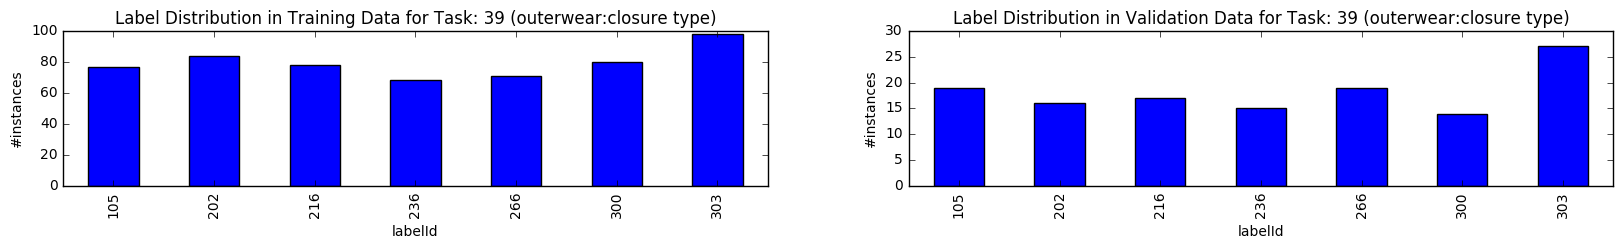

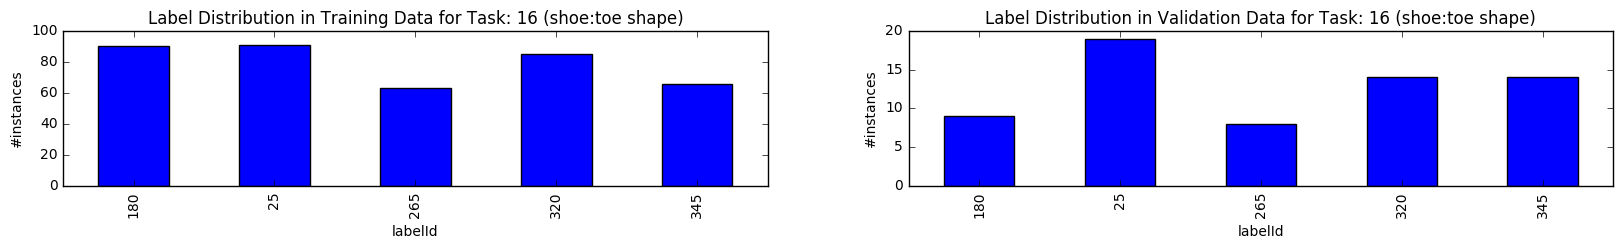

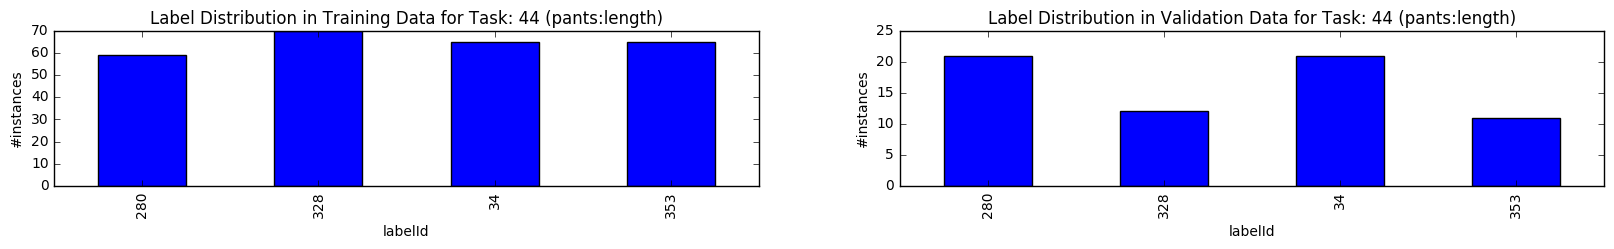

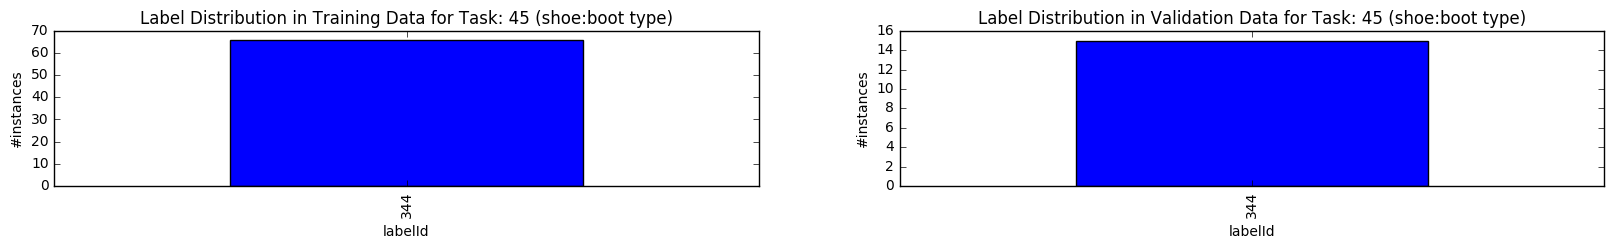

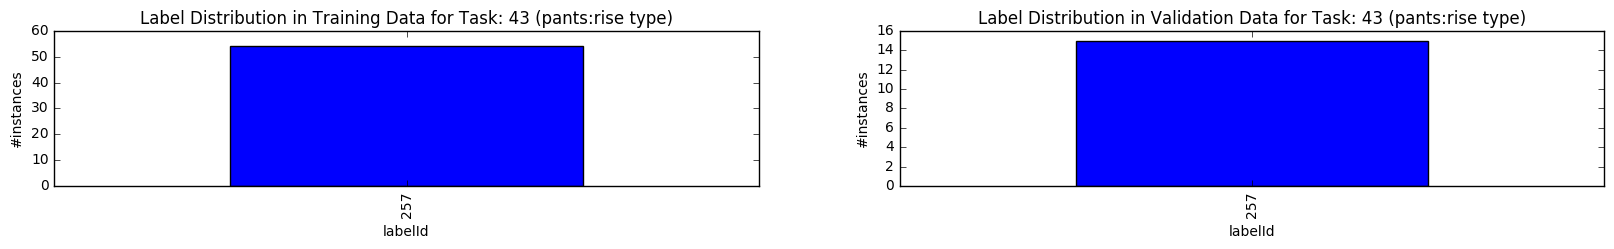

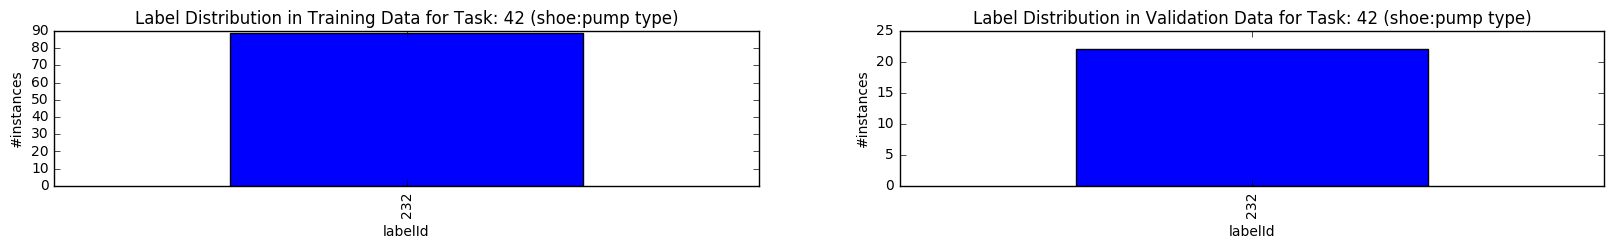

In [10]:
for task in df_train.taskId.unique().tolist():
    plt.figure(figsize=(20, 2))
    plt.subplot(1, 2, 1)
    df_train[df_train.taskId == task].labelId.value_counts().sort_index().plot(kind='bar')
    plt.title('Label Distribution in Training Data for Task: ' + str(task) + ' (' + id_to_task_dict[task] + ')')
    plt.xlabel('labelId')
    plt.ylabel('#instances')
    plt.subplot(1, 2, 2)
    df_valid[df_valid.taskId == task].labelId.value_counts().sort_index().plot(kind='bar')
    plt.title('Label Distribution in Validation Data for Task: ' + str(task) + ' (' + id_to_task_dict[task] + ')')
    plt.xlabel('labelId')
    plt.ylabel('#instances')
    plt.show()

# Image Dimension Distribution

In [11]:
width = []
height = []
channels = []
for _ in tqdm(df_train.imageId.unique().tolist()):
    img = cv2.imread(_)
    try:
        x, y, z = img.shape
    except AttributeError:
        continue
    width.append(y)
    height.append(x)
    channels.append(z)

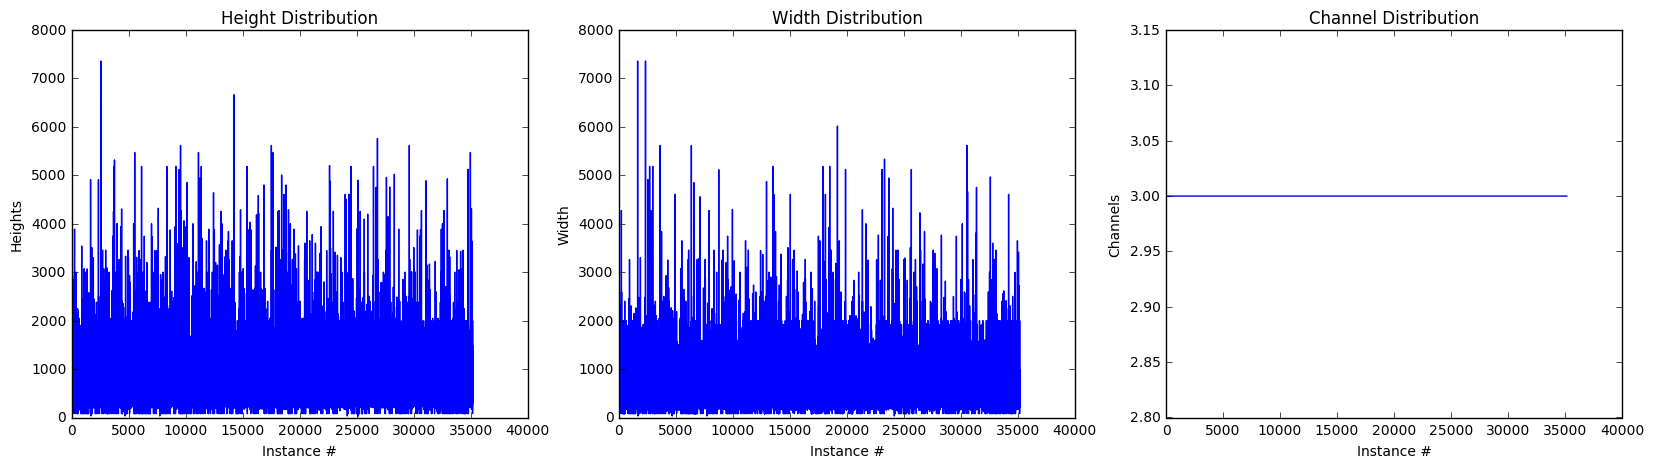

In [12]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title("Height Distribution")
plt.ylabel('Heights')
plt.xlabel('Instance #')
plt.plot(list(range(len(height))), height)
plt.subplot(1, 3, 2)
plt.title("Width Distribution")
plt.ylabel('Width')
plt.xlabel('Instance #')
plt.plot(list(range(len(width))), width)
plt.subplot(1, 3, 3)
plt.title("Channel Distribution")
plt.ylabel('Channels')
plt.xlabel('Instance #')
plt.plot(list(range(len(channels))), channels)
plt.show()

# Image Dimension Statistics

In [13]:
df_image_stats = pd.DataFrame.from_dict({'height': height, 'width': width, 'channel': channels})

In [14]:
cols = ['height', 'width']
for _ in cols:
    print(_)
    print("\tMax", df_image_stats[_].max())
    print("\tMin", df_image_stats[_].min())
    print("\tMean", df_image_stats[_].mean())
    print("\tMedian", df_image_stats[_].median())
    print("\tMode", df_image_stats[_].mode()[0])

height
	Max 7360
	Min 28
	Mean 723.240542692986
	Median 600.0
	Mode 300
width
	Max 7360
	Min 32
	Mean 619.6175550372603
	Median 565.0
	Mode 300


# Conclusions

- There are a total of 4 objects - **['dress', 'outerwear', 'pants', 'shoe']** over which the attributes are to be predicted.
- **Attributes intersect** between two given objects but the **task IDs assigned to these attributes are exclusive**. Because of this it would be possible to train a classifier at object level.
- Labels are practically exclusive (with **limited intersections**) since the values on-diagonal are much greater than those off-diagonal
- The **validation split is stratified** as the distributions of **task IDs over the training and testing images**, and **labels over task IDs** is similar.
- Image dimensions suggest that **reshaping** would be required as the input to pretrained models in keras is around **299*299** and training a bigger image set would also required higher system configuration.

# Model Recommendations

- Since the attributes are related to objects, **use pretrained Image-VGG model weights** to re-train the 4 class object classifier.
- Better to use **Xception Model** with the current system configuration and time constraints.
- Based on the reported accuracies **InceptionResNetV2** would be the ideal choice.
- As a next step there has to be **individual classifier for most of the tasks**.
- Keep as **N/A class for each classifier to assign negative samples**.
- Consider the final probability as the **conditional probability** of an attribute given the probability of an object
- **Note**: The image URLs can be used as the **leaky feature** for the attribute classification task